In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

함수 선언부

In [2]:
def estimate_beta(x, y):
    new_x = inv(np.dot(x.T, x))
    new_y = np.dot(x.T, y)
    beta_hat = np.dot(new_x, new_y)
    return beta_hat

def make_intercept(x):
    temp = np.ones((len(x), 1))
    x = np.hstack([temp, x])
    return x

def make_MSE(m1, m2, Y):
    beta_matrix = np.dot(m1, m2)
    e_matrix = np.subtract(Y, beta_matrix)
    SSE = np.dot(e_matrix.T, e_matrix)
    MSE = SSE / (len(Y) - len(m1.T) - 2)
    return MSE

데이터 입출력

In [3]:
data = pd.read_csv("Auction_master_train.csv", sep=",")
data = data.dropna(axis=1)

필요 데이터 추출 및 선언

In [4]:
x_value = np.array(list(data['point.x'].values))
y_value = np.array(list(data['point.y'].values))
Hammer_Price = np.array(list(data['Hammer_price'].values))
total_addr_do = np.array(list(data['addr_do'].values))
total_addr_si = np.array(list(data['addr_si'].values))
total_compnay_list = np.array(list(data['Appraisal_company'].values))
Minimum_sales_price = np.array(list(data['Minimum_sales_price'].values))
Claim_price = np.array(list(data['Claim_price'].values))
Total_appraisal_price = np.array(list(data['Total_appraisal_price'].values))

In [5]:
company_list = []
for i in data['Appraisal_company'].values:
    if i not in company_list:
        company_list.append(i)

addr_do_list = []
for i in data['addr_do'].values:
    if i not in addr_do_list:
        addr_do_list.append(i)

addr_si_list = []
for i in data['addr_si'].values:
    if i not in addr_si_list:
        addr_si_list.append(i)

선형회귀분석 부분

1. 변수간 분리

In [6]:
category_feature = [col for col in data.columns if data[col].dtypes == "object"]
continuous_feature = data.drop(category_feature, axis=1)
continuous_feature = continuous_feature.drop("Hammer_price", axis=1)

In [7]:
new_data = pd.DataFrame()
for col in category_feature:
    temp = []
    temp_value = []
    for index in data[col]:
        if index not in temp:
            temp.append(index)
            temp_value.append(len(temp))

        else:
            for num, i in enumerate(temp):
                if index == i:
                    temp_value.append(num)
    new_data[col] = temp_value

2. X, y의 분리

In [8]:
X = pd.concat([new_data, continuous_feature], axis=1) #위의 전처리 과정을 거친 데이터 프레임을 적용
y = data['Hammer_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ss = StandardScaler()
X_train_s = ss.fit_transform(X_train)
X_test_s = ss.transform(X_test)

In [9]:
model = LinearRegression()
model.fit(X_train_s, y_train)
print(model.score(X_train, y_train))

-5.442031265913901e+17


In [10]:
sk.metrics.mean_squared_error(y_train, model.predict(X_train))
print(model.coef_)
print(model.intercept_)

[ 1.02236676e+06  5.60183463e+06  3.20775713e+06 -1.35416504e+06
  4.15081939e+06 -6.11679362e+05 -1.87866211e+06  9.16512737e+05
  6.06504946e+07 -6.90078277e+06  9.21089971e+06 -9.14161099e+05
 -8.88463682e+04  6.61482336e+06  1.57514830e+06 -6.01257421e+06
 -7.11869630e+06  2.30637877e+06 -5.87654847e+05 -9.81320713e+06
  4.79261346e+06 -2.08970060e+07  3.37669732e+07  2.46078274e+06
  3.55479278e+07 -5.13382491e+07 -2.74024840e+07  4.50486470e+06
  5.42491727e+07  5.63370574e+08  3.66528372e+05 -2.64055229e+06
 -1.08879992e+07  5.35825853e+07]
479353347.9463139


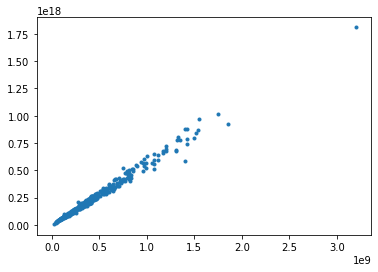

In [11]:
y_pred = model.predict(X_test)
plt.plot(y_test, y_pred, '.')
x = np.linspace(0, 330, 100)
y = x
plt.plot(x,y)
plt.show()

1. X = 경도, 위도, 시/도 Y = 낙찰가

In [12]:
data_do = []

# 인덱싱 과정
for i, addr in enumerate(total_addr_do):
    # 부산이면 0
    if addr in addr_do_list[0]:
        data_do.append(0)
    # 서울이면 1
    else:
        data_do.append(1)

tmp = np.column_stack([x_value, y_value])
X_1 = np.column_stack([tmp, np.array(data_do)])
Y_1 = np.transpose(Hammer_Price)
result_1 = estimate_beta(make_intercept(X_1), Y_1)

print(make_MSE(make_intercept(X_1), result_1, Y_1))

2.5580095700967638e+17


2. X = 청구금액, 최저매각가격, 시/군/구 Y = 낙찰가

In [13]:
data_si = {}
data_si_indexing = []

# 인덱싱 과정
for i, si in enumerate(addr_si_list):
    data_si[si] = i

for si in total_addr_si:
    data_si_indexing.append(data_si[si])

tmp = np.column_stack([Claim_price, Minimum_sales_price])
X_2 = np.column_stack([tmp, np.array(data_si_indexing)])
Y_2 = np.transpose(Hammer_Price)
result_2 = estimate_beta(make_intercept(X_2), Y_2)

print(make_MSE(make_intercept(X_2), result_2, Y_2))

3326205406602390.0


3. X = 총 감정가, 감정사 Y = 낙찰가

In [14]:

data_company = {}
data_company_indexing = []

# 인덱싱 과정
for i, cp in enumerate(company_list):
    data_company[cp] = i

for cp in total_compnay_list:
    data_company_indexing.append(data_company[cp])

X_3 = np.column_stack([Total_appraisal_price, data_company_indexing])
Y_3 = np.transpose(Hammer_Price)
result_3 = estimate_beta(make_intercept(X_3), Y_3)


print(make_MSE(make_intercept(X_3), result_3, Y_3))

2.64400565393222e+16
